In [1]:
import cv2
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
def read_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels

# 讀取真人照片和AI換臉照片
real_images, real_labels = read_images_from_folder(r"C:\Users\p6sje\Desktop\picture\real", 0)
fake_images, fake_labels = read_images_from_folder(r"C:\Users\p6sje\Desktop\picture\fake", 1)

# 合併數據和標籤
all_images = real_images + fake_images
all_labels = real_labels + fake_labels

# 特徵提取
sift = cv2.SIFT_create()
all_descriptors = []
all_labels_expanded = []

for img, label in zip(all_images, all_labels):
    keypoints, descriptors = sift.detectAndCompute(img, None)
    all_descriptors.append(descriptors)
    all_labels_expanded.append(label)

# 將所有描述子疊加起來
all_descriptors_stacked = np.vstack(all_descriptors)

# 使用PCA進行降維
n_components = 80  # 你可以根據需要調整這個值
pca = PCA(n_components=n_components)
pca.fit(all_descriptors_stacked)

# 對每個圖像的描述子進行PCA降維並計算均值特徵向量
reduced_features = []
for descriptors in all_descriptors:
    reduced_descriptors = pca.transform(descriptors)
    mean_feature = np.mean(reduced_descriptors, axis=0)
    reduced_features.append(mean_feature)

reduced_features = np.array(reduced_features)
all_labels_expanded = np.array(all_labels_expanded)

# 切分訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(reduced_features, all_labels_expanded, test_size=0.3, random_state=42)

# 訓練SVM分類器
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# 預測測試集
y_pred = svm.predict(X_test)


print("Original Descriptors shape:", descriptors.shape)
print("Reduced Descriptors shape:", reduced_descriptors.shape)

# 評估分類器
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Original Descriptors shape: (911, 128)
Reduced Descriptors shape: (911, 80)
Accuracy: 0.589648798521257
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.93      0.72       311
           1       0.58      0.13      0.21       230

    accuracy                           0.59       541
   macro avg       0.58      0.53      0.47       541
weighted avg       0.59      0.59      0.51       541



Prediction for test1: Real


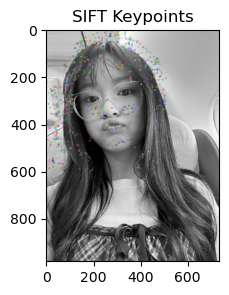

Prediction for test2: AI-generated


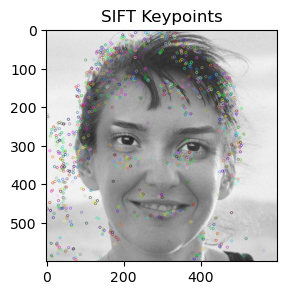

In [5]:
    # 測試新圖片
    def predict_image(image_path):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        keypoints, descriptors = sift.detectAndCompute(img, None)
        if descriptors is not None:
            reduced_descriptors = pca.transform(descriptors)
            mean_feature = np.mean(reduced_descriptors, axis=0)
            prediction = svm.predict([mean_feature])
            return prediction
        else:
            return None

    test1_path = r"C:\Users\p6sje\Desktop\picture\aa217a05390ed93908e9081ad0b50b3c.jpg"
    test2_path = r"C:\Users\p6sje\Desktop\picture\fake\easy_46_1100.jpg"
    prediction = predict_image(test1_path)
    print("Prediction for test1:", "AI-generated" if prediction == 1 else "Real")
    prediction = predict_image(test2_path)


    # 可視化關鍵點（選擇性）
    image_with_keypoints = cv2.drawKeypoints(cv2.imread(test1_path, cv2.IMREAD_GRAYSCALE), keypoints, None)
    plt.figure(figsize=(6, 3))
    plt.imshow(image_with_keypoints, cmap='gray')
    plt.title('SIFT Keypoints')
    plt.show()
    
    print("Prediction for test2:", "AI-generated" if prediction == 1 else "Real")
    image_with_keypoints = cv2.drawKeypoints(cv2.imread(test2_path, cv2.IMREAD_GRAYSCALE), keypoints, None)
    plt.figure(figsize=(6, 3))
    plt.imshow(image_with_keypoints, cmap='gray')
    plt.title('SIFT Keypoints')
    plt.show()
    

